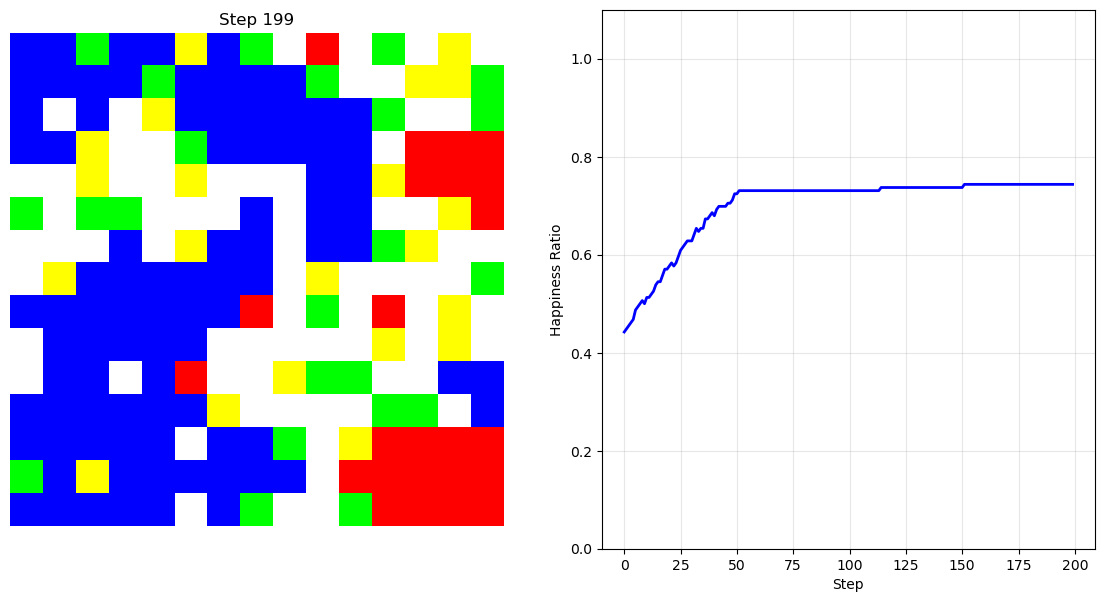

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from time import sleep

# Parameters
N1, N2 = 15, 15
# Controls how many cells are occupied (vs empty) when initializing the grid.
probability = 0.7
# Controls how many cells of type 1 (blue) are in the grid.
ratio = 0.6
# Controls how much the grandma affects the happiness of the other agents.
grandma_affect = 0.05
# Controls how much the drummer affects the happiness of the other agents.
drummer_affect = 0.03
neighborhood = np.zeros((N1, N2), dtype=int)
# Controls the threshold for happiness.
happiness_threshold = 0.5
make_drummer_and_granny_static = True

# Site percolation
def initialize_schelling_grid(neighborhood, probability, ratio):
    empty = []
    active = []
    N1 = neighborhood.shape[0]
    N2 = neighborhood.shape[1]
    for i in range(N1): #for cell in every row
        for j in range(N2): #and every column
            die = random.uniform(0, 1)
            if die < probability:
              die_type = random.uniform(0, 1)
              if die_type < ratio:
                neighborhood[(i,j)] = 1
                active.append((i,j))
              else:
                neighborhood[(i,j)] = np.random.randint(2, 5) # 3 = Sweet Grandma that bakes everyone cookies 4 = Drummer that plays loud, late, early, and sucks
                active.append((i,j))
            else:
              neighborhood[(i,j)] = 0
              empty.append((i,j))


    return neighborhood, empty, active
    
neighborhood, empty, active = initialize_schelling_grid(neighborhood, probability, ratio)

def check_happiness(neighborhood, i, j, agent_type=None):
    if agent_type is None:
        current_type = neighborhood[i, j]
    else:
        current_type = agent_type
    
    # Can't check happiness for empty cells
    if current_type == 0:
        return 0
    
    N1, N2 = neighborhood.shape
    
    # Get all valid neighbors
    neighbors = []
    
    # Define the 8 possible neighbor directions (including diagonals)
    directions = [
        (-1, -1), (-1, 0), (-1, 1),  # top row
        (0, -1),           (0, 1),    # same row (left and right)
        (1, -1),  (1, 0),  (1, 1)     # bottom row
    ]
    
    for di, dj in directions:
        ni, nj = i + di, j + dj
        # Check if neighbor is within bounds
        if 0 <= ni < N1 and 0 <= nj < N2:
            neighbors.append(neighborhood[ni, nj])
    
    # Count neighbors of the same type (excluding empty cells)
    # How do we want to do this? - Question for Jackson and team
    # Option 1: grandma and drummer are included in the same_type count
    # this leads to clustering of all types where grandmas are often on borders of other types
    same_type = sum(1 for n in neighbors if n == current_type)
    different_type = sum(1 for n in neighbors if n != current_type and n != 0)
    # Option 2: grandma and drummer are excluded from the same_type count
    # this leads to a happiness plateau where it levels off
    # same_type = sum(1 for n in neighbors if n == current_type and n != 3 and n != 4)
    # different_type = sum(1 for n in neighbors if n != current_type and n != 0 and n != 3 and n != 4)

    contains_sweet_grandma = any(n == 3 for n in neighbors)
    contains_drummer = any(n == 4 for n in neighbors)
    
    # Only count non-empty neighbors
    non_empty_neighbors = same_type + different_type
    
    # Handle edge case of no neighbors
    if non_empty_neighbors == 0:
        return 1
    
    current_happiness = same_type / non_empty_neighbors
    if contains_sweet_grandma:
        current_happiness += grandma_affect

    if contains_drummer:
        current_happiness -= drummer_affect
        
    return True if current_happiness >= happiness_threshold else False


def run_schelling(neighborhood, empty, active):
    N1, N2 = neighborhood.shape
    
    # Iterate over a copy of active to avoid modification issues
    for cell in list(active):
        i, j = cell
        agent_type = neighborhood[i, j]
        
        if make_drummer_and_granny_static and (agent_type == 4 or agent_type == 3):
            continue
        # Check current happiness
        happiness = check_happiness(neighborhood, i, j)
        
        if not happiness and len(empty) > 0:
            # Agent is unhappy - try to move
            empty_idx = random.randint(0, len(empty) - 1)
            potential_i, potential_j = empty[empty_idx]
            
            # Check what happiness would be at the new location
            # (passing agent_type since that cell is currently empty)
            potential_happiness = check_happiness(neighborhood, potential_i, potential_j, agent_type)
            
            # Move if new location would make agent happy
            if potential_happiness:
                # Perform the move
                neighborhood[potential_i, potential_j] = agent_type
                neighborhood[i, j] = 0  # Mark old location as empty
                
                # Update lists
                empty.pop(empty_idx)  # Remove new location from empty
                empty.append((i, j))  # Add old location to empty
                active.remove(cell)   # Remove old location from active
                active.append((potential_i, potential_j))  # Add new location to active
                #print(f'Old location is {i},{j}')
                #print(f'New location is {potential_i},{potential_j}')
                break
    return neighborhood, empty, active

# You can visualize as animation or iteration by iteration
happiness_history = []

# Animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Run and animate
for iteration in range(200):
    # Run one iteration FIRST
    neighborhood, empty, active = run_schelling(neighborhood, empty, active)
    # Calculate happiness AFTER the move
    total_happiness = []
    for cell in active:
        happiness_cell = cell
        total_happiness.append(check_happiness(neighborhood, happiness_cell[0], happiness_cell[1]))
    
    happiness_ratio = total_happiness.count(True) / len(total_happiness)
    happiness_history.append(happiness_ratio)
    
    # Update visualization
    colors = np.zeros((*neighborhood.shape, 3))
    colors[neighborhood == 0] = [1, 1, 1]  # White
    colors[neighborhood == 1] = [0, 0, 1]  # Blue
    colors[neighborhood == 2] = [1, 0, 0]  # Red
    colors[neighborhood == 3] = [0, 1, 0]  # Green = Granny
    colors[neighborhood == 4] = [1, 1, 0]  # Yellow = Drummer
    
    ax1.clear()
    ax2.clear()
    ax1.imshow(colors, interpolation='nearest')
    ax1.set_title(f'iteration {iteration}')
    ax1.axis('off')
    
    ax2.plot(happiness_history, color='blue', linewidth=2)
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('Happiness Ratio')
    ax2.set_ylim([0, 1.1])
    ax2.grid(True, alpha=0.3)
    
    display.display(fig)
    display.clear_output(wait=True)
    sleep(0.05)  # Adjust speed here
    
    # Check if converged (now checking the correct happiness)
    if happiness_ratio == 1:
        print(f'Finished running in {iteration} moves')
        break

plt.savefig('Schelling_final.png')
plt.show()

# iteration by iteration

# def visualize_grid(neighborhood, iteration=0):
#     plt.figure(figsize=(8, 8))
#     # Create color map: 0=white, 1=blue, 2=red
#     colors = np.zeros((*neighborhood.shape, 3))
#     colors[neighborhood == 1] = [0, 0, 1]  # Blue
#     colors[neighborhood == 2] = [1, 0, 0]  # Red
#     colors[neighborhood == 0] = [1, 1, 1]  # White
    
#     plt.imshow(colors, interpolation='nearest')
#     plt.title(f'iteration {iteration}')
#     plt.axis('off')
#     plt.show()

# def visualize_grid_and_happiness(neighborhood, iteration=0):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
#     colors = np.zeros((*neighborhood.shape, 3))
#     colors[neighborhood == 0] = [1, 1, 1]  # White
#     colors[neighborhood == 1] = [0, 0, 1]  # Blue
#     colors[neighborhood == 2] = [1, 0, 0]  # Red
#     colors[neighborhood == 3] = [0, 1, 0]  # Green = Granny
#     colors[neighborhood == 4] = [1, 1, 0]  # Yellow = Drummer
    
#     ax1.imshow(colors, interpolation='nearest')
#     fig.suptitle(f'iteration {iteration}')
#     ax2.plot(happiness_history)
#     plt.show()

# happiness_history = []
# visualize_grid_and_happiness(neighborhood, 0)
# for iteration in range(200):
#     total_happiness = []
#     for item in active:
#         happiness_cell = item
#         total_happiness.append(check_happiness(neighborhood,happiness_cell[0],happiness_cell[1]))
#     happiness_ratio = 1 - (total_happiness.count(-1)) / (total_happiness.count(1))
#     happiness_history.append(happiness_ratio)
#     run_schelling(neighborhood,empty,active)
#     if happiness_ratio == 1:
#         visualize_grid_and_happiness(neighborhood, iteration)
#         print(f'Finished running in {iteration} moves')
#         break
#     if iteration % 5 == 4:  # Show every 5th iteration
#         visualize_grid_and_happiness(neighborhood, iteration + 1)
